# Preimports

In [2]:
import numpy as np
import pandas as pd
import pyaudio
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.fftpack import fft
from scipy.signal import butter, lfilter, freqz
from time import *

%matplotlib inline

In [3]:
fq = pd.read_csv('notesFrequencies',
                 index_col=0,
                 header=None,
                 names=['Note','Frequency','Wavelenght']).T

intervals = pd.read_csv('intervals',
                        header=None,
                        names = ['Semitone', 'R1', 'R2', 'Interval', 'Natural', 'HS1', 'HS2'])

# Gerando o Sinal

In [38]:
fs = 44100  # sampling rate, Hz, inteiro
duration = 20

In [117]:
fqs = list()
samples = list()

fqs.append(fq['G3'][0])
fqs.append(fq['G4'][0])
fqs.append(fq['B4'][0])
fqs.append(fq['D5'][0])

for f in fqs:
    samples.append((np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32))

result = sum(samples)/len(samples)

In [118]:
# fourier fast transform
N = len(result)
T = 1.0 / fs
x = np.linspace(0.0, N*T, N)
y = result
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

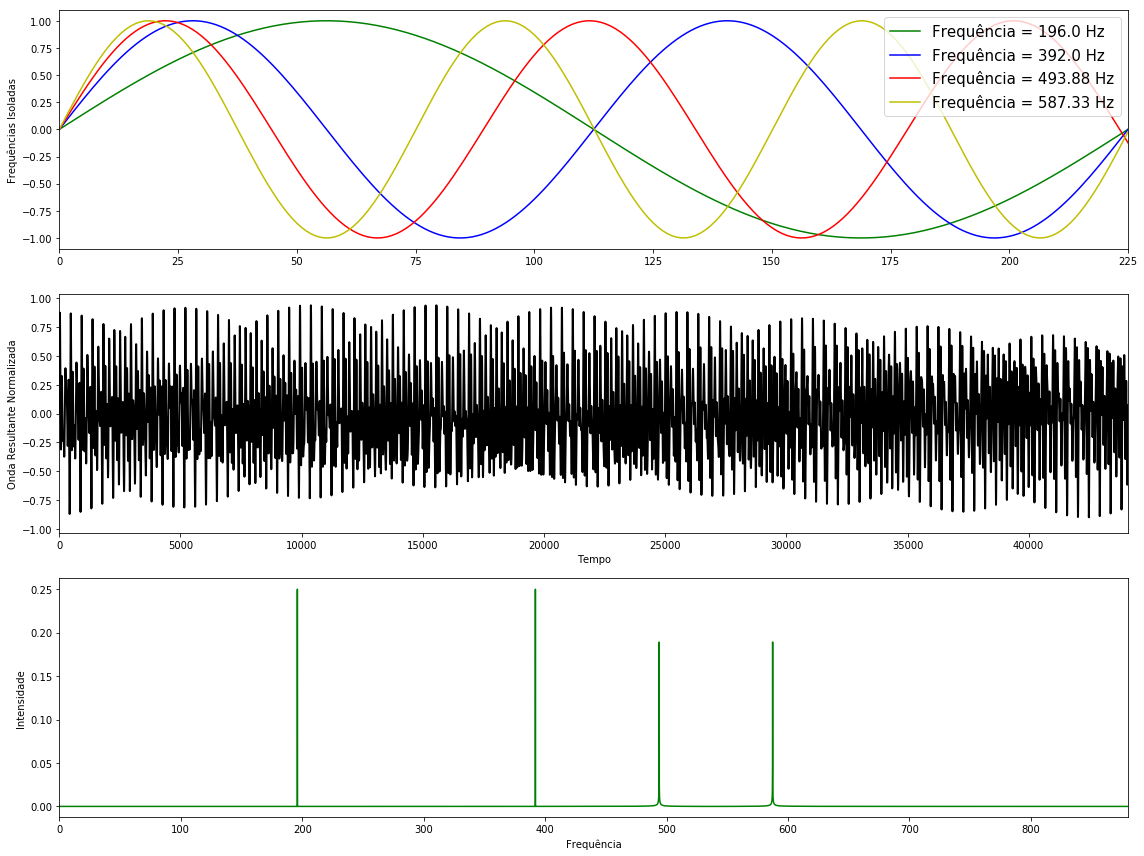

In [119]:
xmax = fs

fig = plt.figure(figsize=(16, 12)) 
gs = gridspec.GridSpec(3, 1) 

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

# plotando ondas separadas
ax0.plot(range(0,len(samples[0])), samples[0], color = 'g')
ax0.plot(range(0,len(samples[1])), samples[1], color = 'b')
ax0.plot(range(0,len(samples[2])), samples[2], color = 'r')
ax0.plot(range(0,len(samples[2])), samples[3], color = 'y')
ax0.legend(('Frequência = {} Hz'.format(fqs[0]), 
            'Frequência = {} Hz'.format(fqs[1]), 
            'Frequência = {} Hz'.format(fqs[2]),
            'Frequência = {} Hz'.format(fqs[3])),
            loc='upper right', prop={'size': 15})
ax0.set_ylabel('Frequências Isoladas')
ax0.set_xlim(0,fs/min(fqs))

# domínio tempo da onda resultante
ax1.plot(range(0,len(result)), result, color = 'black', linewidth=2)
ax1.set_xlabel('Tempo')
ax1.set_ylabel('Onda Resultante Normalizada')
ax1.set_xlim(0,xmax)

# domínio frequência da onda resultante
ax2.plot(xf, 2.0/N * np.abs(yf[0:N//2]), color = 'g')
ax2.set_xlim(0,880)
ax2.set_xlabel('Frequência')
ax2.set_ylabel('Intensidade')

fig.tight_layout();

# Reproduzindo o Sinal de Áudio

In [120]:
wave = result
volume = 1

p = pyaudio.PyAudio()

# for paFloat32 sample values must be in range [-1.0, 1.0]
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=fs,
                output=True)

# play. May repeat with different volume values (if done interactively) 

stream.write(volume*wave)

stream.stop_stream()
stream.close()

p.terminate()

# Efeitos Digitais [WIP]

### Filtro Passa-Baixa

In [436]:
def butter_lowpass(cutoff, fs=fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y